In [ ]:
using Serialization
using ITensors, ITensorMPS, Plots
using ProgressMeter, Statistics, Random, SparseArrays
using JLD2, Printf
include("ldpc_tanner_loops.jl")
include("gallagerBP.jl")
push!(LOAD_PATH, "functions/")
using BP

In [49]:
pcmat = [1 1; 1 1]
m, n = size(pcmat)
tannerloopslist = [find_tanner_loops(pcmat, d; max_length=5) for d in 1:n]
errors_true = [0, 1]
syndrome = pcmat * errors_true .% 2
pbias = 0.5

# Decode each data qubit
relativenorm = []
selfconsistencyviolation = []

# Decode
data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome, pbias)
errors_loops = Int.(-1 .* ones(n))
errors_no_loops = Int.(-1 .* ones(n))
tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors), syn_tensors)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links;random_part=0.1) 
messages = BP.message_passing(tensors,messages,edges,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true);


for d = 1:n
    probs = get_marginal(vcat(data_tensors, syn_tensors), adj_mat, messages, d)
    errors_no_loops[d] = tensorargmax(probs)
    push!(selfconsistencyviolation,BP.check_self_consistency(vcat(get_marginal_data_tensors(data_tensors, data_indices, errors), syn_tensors), messages, adj_mat)[2])
    # Get loops for this data qubit
    tannerloops = tannerloopslist[d]
    loop_list = [tannerloop.edges for tannerloop in tannerloops] 
    data_bits_involved_list = [tannerloop.data_bits for tannerloop in tannerloops]
    check_bits_involved_list = [tannerloop.check_bits for tannerloop in tannerloops]
    
    loopprobs = ITensor([0,0], data_indices[d])
    for (i, loop) in enumerate(loop_list)
    #     # should we do this?
    #     tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors), syn_tensors)
    #     messages = BP.selective_message_passing(tensors, messages, loop, edges, adj_mat)
        data_bits_involved = data_bits_involved_list[i] 
        check_bits_involved = check_bits_involved_list[i] 
        mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops; exclude=[d]), syn_tensors)
        
        if !isempty(setdiff(data_bits_involved, [d]))
            normlz1 = scalar(prod([get_marginal(mtensors, adj_mat, messages, other_data_bit) 
                                for other_data_bit in collect(setdiff(data_bits_involved, [d]))]))
        else
            normlz1 = 1.0
        end
        
        if !isempty(check_bits_involved)
            normlz2 = scalar(prod([get_marginal(mtensors, adj_mat, messages, n+check_bit) 
                                for check_bit in check_bits_involved]))
        else
            normlz2 = 1.0
        end
        
        normlz = normlz1 * normlz2
        if normlz != 0
            change = BP.loop_contribution(loop, messages, mtensors, edges, links, adj_mat) 
            # println(change)
            loopprobs += change / normlz
        end
    end
    push!(relativenorm,norm(loopprobs)/norm(probs))
    # println("loopcorr probs...", loopprobs)
    loopcorr = tensorargmax(probs + loopprobs)  
    errors_loops[d] = loopcorr

    # Early stopping: if both decoders made errors, no point continuing
    if (errors_no_loops[d] != errors_loops[d])  
        println("loop corr happened")
    end 
end
println(" decoder errors?... ", (sum(errors_loops .!= errors_true)/n ))
println(" syndrome correctness...", (syndrome == pcmat * errors_loops .% 2))
# println("loopcorr decoder errors?... ", (sum(errors_loops .!= errors_true)/n ))
# println("loopcorr syndrome correctness...", (syndrome == pcmat * errors_loops .% 2))
# println("self consistency violation per sampled bit...", sum(selfconsistencyviolation)/n)
# println("relative loop norm per bit...", sum(relativenorm)/n)

loop corr happened
loop corr happened
 decoder errors?... 1.0
 syndrome correctness...true


In [ ]:

function fixed_point_messages(tensors)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages = BP.message_passing(tensors,messages,edges,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true)
    return messages 
end 

In [37]:
d_v = 3 
d_c = 4
n = 512 
p = 0.18
pbias = p 
max_loop_order = 4
pcmat = gallager_ldpc_matrix(n, d_v, d_c)
m, n = size(pcmat)
tannerloopslist = [find_tanner_loops(pcmat, d; max_length=max_loop_order) for d in 1:n];

In [38]:
# Sample errors iid with probability p
errors_true = [sample_bit(1-p) for _ in 1:n]
println(sum(errors_true) / n)
err_bits = findall(isodd,errors_true)
# Compute syndrome 
syndrome = pcmat * errors_true .% 2
flared_checks = findall(isodd, syndrome);

0.19140625


In [44]:
checklooplist = []
for check in flared_checks
    tl = find_loops_for_check_bit(pcmat, check; max_length = 6)
    if length(tl) > 0 
        push!(checklooplist, tl)
    end 
end 


In [45]:
checklooplist[1]

1-element Vector{TannerLoop}:
 TannerLoop([(164, 610), (244, 610), (244, 669), (164, 669)], Set([244, 164]), Set([98, 157]), 4)

In [39]:
# Decode
data_tensors, syn_tensors, data_indices = get_network(pcmat, syndrome, pbias)
errors_loops = Int.(-1 .* ones(n))
errors_no_loops = Int.(-1 .* ones(n))
tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops), syn_tensors)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links;random_part=0.1) 
messages = BP.message_passing(tensors,messages,edges,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true);

In [ ]:
# Decode each data qubit
relativenorm = []
selfconsistencyviolation = []

for d = 1:n
    probs = get_marginal(vcat(data_tensors, syn_tensors), adj_mat, messages, d)
    errors_no_loops[d] = tensorargmax(probs)
    push!(selfconsistencyviolation,BP.check_self_consistency(vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops), syn_tensors), messages, adj_mat)[2])
    # Get loops for this data qubit
    tannerloops = tannerloopslist[d]
    loop_list = [tannerloop.edges for tannerloop in tannerloops] 
    data_bits_involved_list = [tannerloop.data_bits for tannerloop in tannerloops]
    check_bits_involved_list = [tannerloop.check_bits for tannerloop in tannerloops]
    
    loopprobs = ITensor([0,0], data_indices[d])
    for (i, loop) in enumerate(loop_list)
        # should we do this?
        data_bits_involved = data_bits_involved_list[i] 
        check_bits_involved = check_bits_involved_list[i] 
        mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors_loops; exclude=[d]), syn_tensors)
        
        if !isempty(setdiff(data_bits_involved, [d]))
            normlz1 = scalar(prod([get_marginal(mtensors, adj_mat, messages, other_data_bit) 
                                for other_data_bit in collect(setdiff(data_bits_involved, [d]))]))
        else
            normlz1 = 1.0
        end
        
        if !isempty(check_bits_involved)
            normlz2 = scalar(prod([get_marginal(mtensors, adj_mat, messages, n+check_bit) 
                                for check_bit in check_bits_involved]))
        else
            normlz2 = 1.0
        end
        
        normlz = normlz1 * normlz2
        if normlz != 0
            change = BP.loop_contribution(loop, messages, mtensors, edges, links, adj_mat) 
            # println(change)
            loopprobs += change / normlz
        end
    end
    push!(relativenorm,norm(loopprobs)/norm(probs))
    # println("loopcorr probs...", loopprobs)
    loopcorr = tensorargmax(probs + loopprobs)  
    errors_loops[d] = loopcorr

    # Early stopping: if both decoders made errors, no point continuing
    if (errors_no_loops[d] != errors_loops[d])  
        println("loop corr happened")
    end 
end
println(" decoder errors?... ", (sum(errors_loops .!= errors_true)/n ))
println(" syndrome correctness...", (syndrome == pcmat * errors_loops .% 2))
# println("loopcorr decoder errors?... ", (sum(errors_loops .!= errors_true)/n ))
# println("loopcorr syndrome correctness...", (syndrome == pcmat * errors_loops .% 2))
# println("self consistency violation per sampled bit...", sum(selfconsistencyviolation)/n)
# println("relative loop norm per bit...", sum(relativenorm)/n)

 decoder errors?... 0.162109375
 syndrome correctness...false


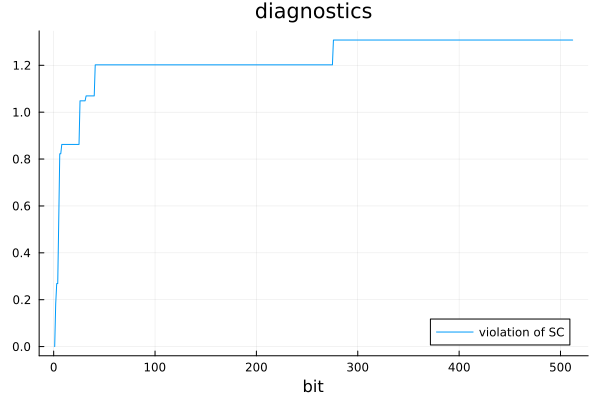

In [41]:
plot(title="diagnostics", xlabel="bit")
plot!(1:n, selfconsistencyviolation, label="violation of SC")

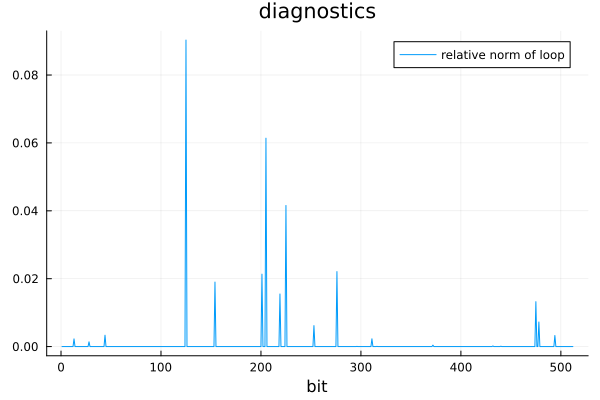

In [31]:
plot(title="diagnostics", xlabel="bit")
plot!(1:n, relativenorm, label="relative norm of loop")


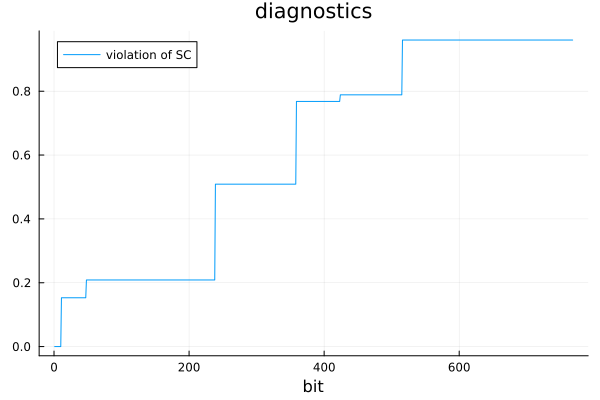